In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install catboost
!pip install hyperopt
!pip install shap
!pip install hdbscan

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/data.csv')

#EDA

In [ ]:
df

,Unnamed: 0.1,Unnamed: 0,year,QUARTER,month,day,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,CONGESTION,DATE,WEEK,weekly_carrier_delay,IsDelayed,departure_date,departure_hour,peak_1,peak_2,temp(in celsius),wind_speed,dew_point,humidity,pressure,weather_code,precipitation
0,0,0,2023,1,1,1,7,9E,N8918B,5531,10397,ATL,"Atlanta, GA",GA,13277,MGM,"Montgomery, AL",AL,825,841.0,16.0,12.0,4.0,829,831.0,2.0,0.0,0.0,64.0,50.0,34.0,147.0,0.0,0.0,0.0,0.0,0.0,686.0,2023-01-01,1,6.719019,0,2023-01-01,8,1,0,10.8,0.0,10.8,100.0,1017.5,5.0,0.0
1,1,1,2023,1,1,1,7,9E,N907XJ,4830,10397,ATL,"Atlanta, GA",GA,12197,HPN,"White Plains, NY",NY,950,947.0,-3.0,29.0,4.0,1214,1213.0,0.0,0.0,0.0,144.0,146.0,113.0,780.0,0.0,0.0,0.0,0.0,0.0,686.0,2023-01-01,1,6.719019,0,2023-01-01,9,0,0,11.9,0.0,11.9,100.0,1017.2,5.0,0.0
2,2,2,2023,1,1,1,7,9E,N8918B,4825,10397,ATL,"Atlanta, GA",GA,10731,BQK,"Brunswick, GA",GA,1710,1705.0,-5.0,11.0,5.0,1814,1802.0,0.0,0.0,0.0,64.0,57.0,41.0,238.0,0.0,0.0,0.0,0.0,0.0,686.0,2023-01-01,1,6.719019,0,2023-01-01,17,0,0,20.3,13.0,11.5,57.0,1018.3,3.0,0.0
3,3,3,2023,1,1,1,7,9E,N924EV,5251,10397,ATL,"Atlanta, GA",GA,13422,MOB,"Mobile, AL",AL,839,829.0,-10.0,19.0,4.0,906,850.0,0.0,0.0,0.0,87.0,81.0,58.0,302.0,0.0,0.0,0.0,0.0,0.0,686.0,2023-01-01,1,6.719019,0,2023-01-01,8,1,0,10.8,0.0,10.8,100.0,1017.5,5.0,0.0
4,4,4,2023,1,1,1,7,9E,N8877A,4639,10397,ATL,"Atlanta, GA",GA,12323,ILM,"Wilmington, NC",NC,900,856.0,-4.0,26.0,4.0,1023,1023.0,0.0,0.0,0.0,83.0,87.0,57.0,377.0,0.0,0.0,0.0,0.0,0.0,686.0,2023-01-01,1,6.719019,0,2023-01-01,9,0,0,10.8,0.0,10.8,100.0,1017.5,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199884,199884,199884,2023,4,12,31,7,YX,N739YX,3683,13930,ORD,"Chicago, IL",IL,12953,LGA,"New York, NY",NY,1400,1358.0,-2.0,52.0,5.0,1727,1741.0,14.0,0.0,0.0,147.0,163.0,106.0,733.0,0.0,0.0,0.0,0.0,0.0,619.0,2023-12-31,52,0.844362,0,2023-12-31,14,0,0,-0.6,9.4,-1.7,92.0,1011.0,14.0,0.2
199885,199885,199885,2023,4,12,31,7,YX,N403YX,4649,13930,ORD,"Chicago, IL",IL,14730,SDF,"Louisville, KY",KY,1510,1505.0,-5.0,34.0,7.0,1732,1738.0,6.0,0.0,0.0,82.0,93.0,52.0,286.0,0.0,0.0,0.0,0.0,0.0,619.0,2023-12-31,52,0.844362,0,2023-12-31,15,0,0,0.0,16.6,-2.2,85.0,1012.6,14.0,0.5
199886,199886,199886,2023,4,12,31,7,YX,N113HQ,4376,10397,ATL,"Atlanta, GA",GA,11278,DCA,"Washington, DC",VA,731,725.0,-6.0,78.0,3.0,920,1007.0,47.0,0.0,0.0,109.0,162.0,81.0,547.0,0.0,0.0,47.0,0.0,0.0,766.0,2023-12-31,52,0.844362,1,2023-12-31,7,0,0,-1.4,0.0,-2.5,92.0,1021.3,1.0,0.0
199887,199887,199887,2023,4,12,31,7,YX,N758YX,3668,13930,ORD,"Chicago, IL",IL,12339,IND,"Indianapolis, IN",IN,715,709.0,-6.0,62.0,7.0,929,951.0,22.0,0.0,0.0,74.0,102.0,33.0,177.0,0.0,0.0,22.0,0.0,0.0,619.0,2023-12-31,52,0.844362,1,2023-12-31,7,0,0,1.7,20.5,-2.8,72.0,1010.4,4.0,0.0


In [ ]:
df.isna().sum()

,0
Unnamed: 0.1,0
Unnamed: 0,0
year,0
QUARTER,0
month,0
day,0
DAY_OF_WEEK,0
OP_UNIQUE_CARRIER,0
TAIL_NUM,0
OP_CARRIER_FL_NUM,0


In [ ]:
data=df

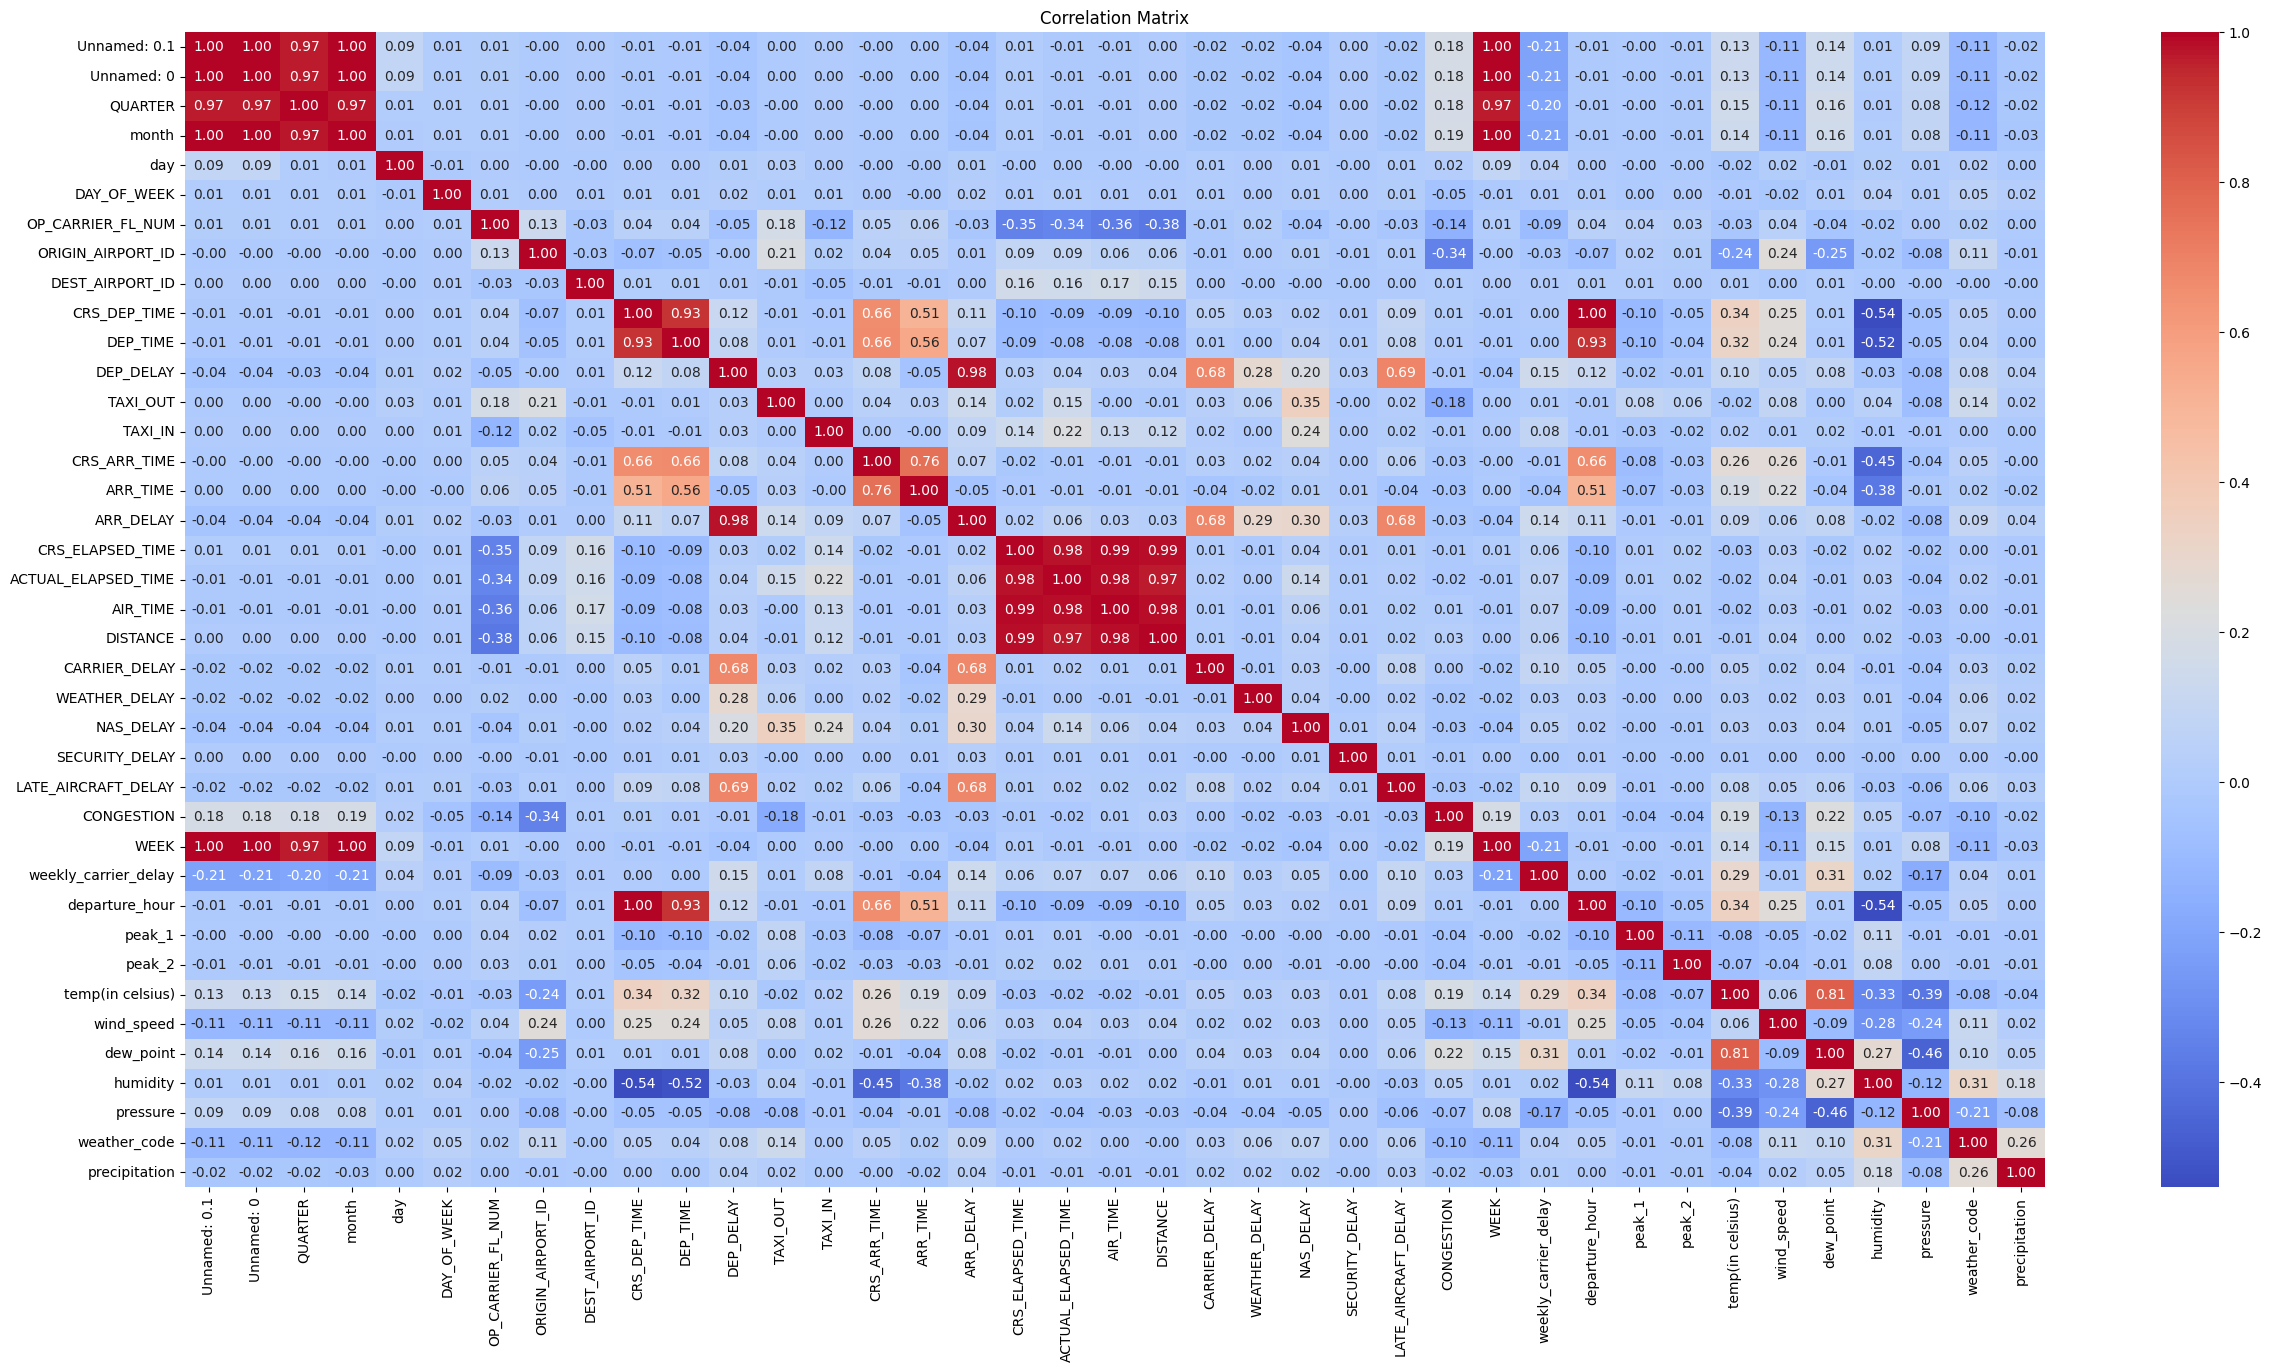

In [ ]:
numerical_data = df.select_dtypes(include=['number'])
numerical_data.drop(columns=['CANCELLED', 'DIVERTED', 'year','IsDelayed'], inplace=True)
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(30, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
for dataset in data:
    data.loc[data['ARR_DELAY'] <= 15, 'Status'] = 0
    data.loc[data['ARR_DELAY'] >= 15, 'Status'] = 1
    data.loc[data['ARR_DELAY'] >= 60, 'Status'] = 2
    data.loc[data['ARR_DELAY'] >= 120, 'Status'] = 3

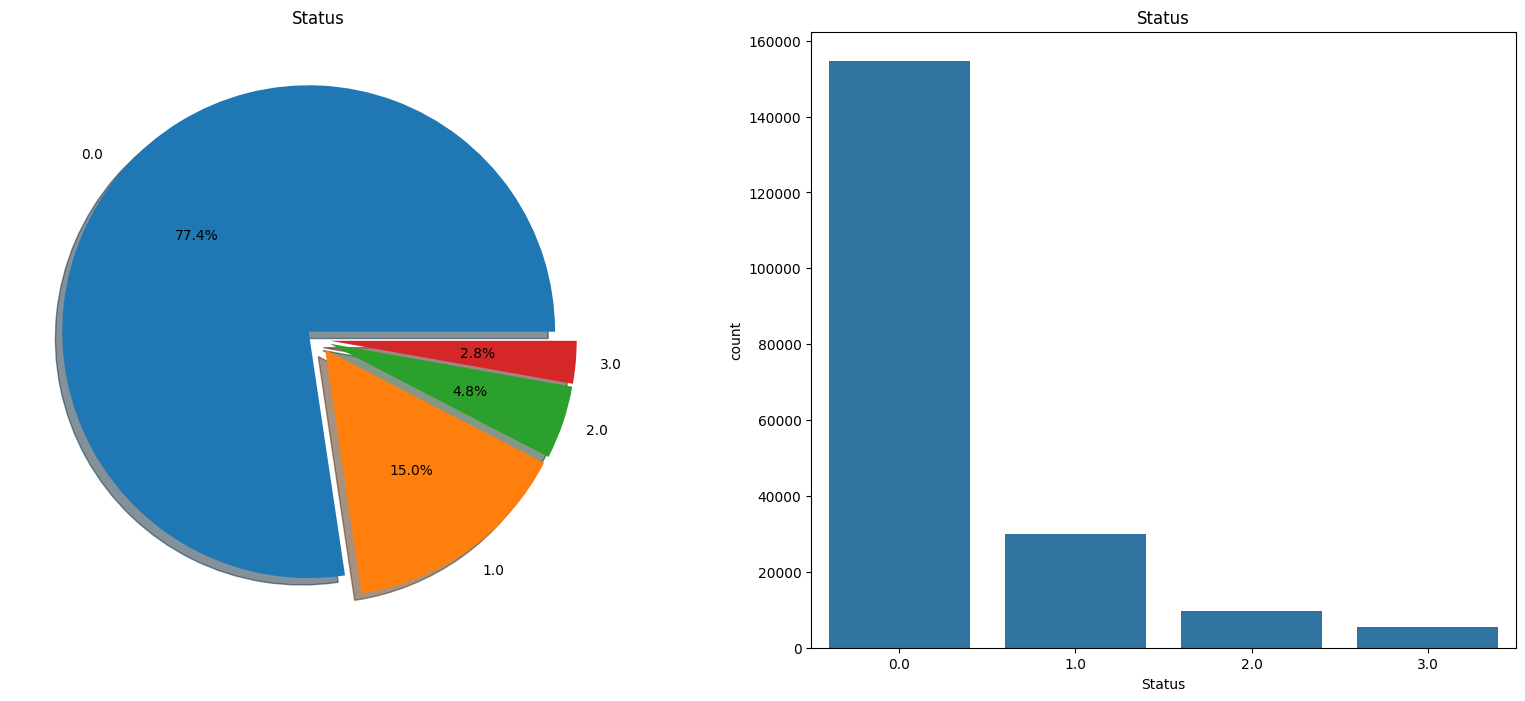

Status represents whether the flight was on time (0), slightly delayed (1), highly delayed (2), extreme delay (3)


In [ ]:
f,ax=plt.subplots(1,2,figsize=(20,8))
status_counts = data['Status'].value_counts()
explode = [0.05] * len(status_counts)
status_counts.plot.pie(explode=explode, autopct='%1.1f%%', ax=ax[0], shadow=True)

ax[0].set_title('Status')
ax[0].set_ylabel('')
sns.countplot(x='Status', order=data['Status'].value_counts().index, data=data, ax=ax[1])
ax[1].set_title('Status')
plt.show()

print('Status represents whether the flight was on time (0), slightly delayed (1), highly delayed (2), extreme delay (3)')

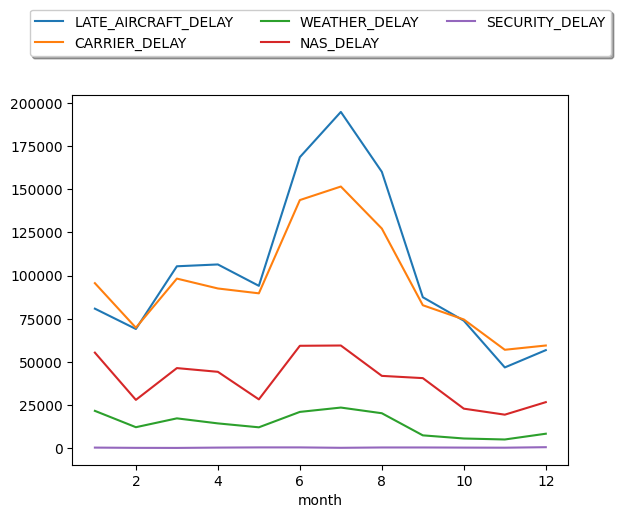

In [ ]:
# Check for duplicate column names
duplicate_columns = data.columns[data.columns.duplicated()]

# If duplicate columns exist, print them
if len(duplicate_columns) > 0:
    print("Duplicate columns found:", duplicate_columns)
    columns_to_keep = ['month', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
    data = data[[c for c in columns_to_keep if c not in duplicate_columns]]


df2 = data.filter(['month','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY'], axis=1)
df2 = df2.groupby('month')[['LATE_AIRCRAFT_DELAY','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY']].sum().plot()
df2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3, fancybox=True, shadow=True)
plt.show()

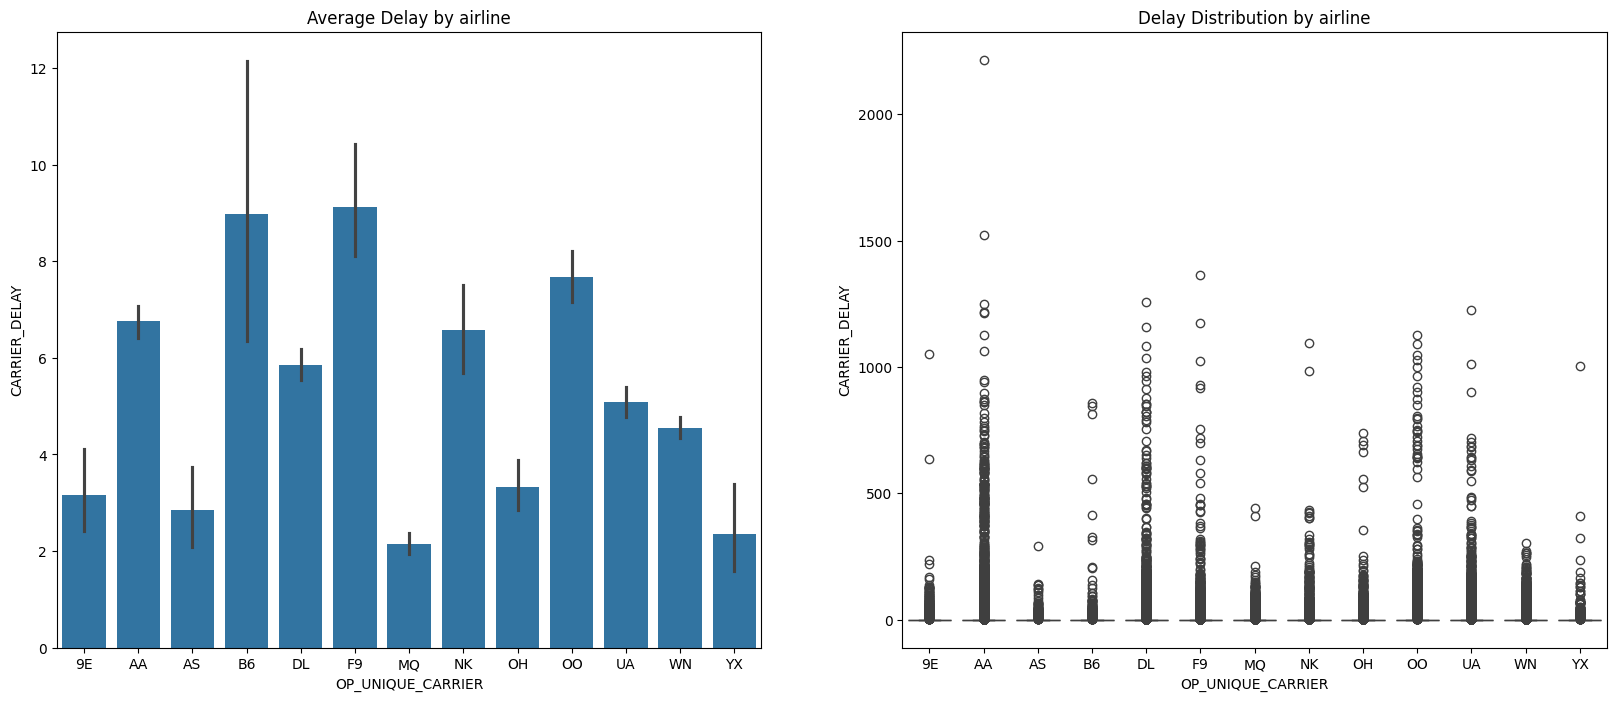

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 2, figsize=(20, 8))


sns.barplot(x='OP_UNIQUE_CARRIER', y='CARRIER_DELAY', data=data, ax=ax[0])

ax[0].set_title('Average Delay by airline')
sns.boxplot(x='OP_UNIQUE_CARRIER', y='CARRIER_DELAY', data=data, ax=ax[1])
ax[1].set_title('Delay Distribution by airline')

# Remove or comment out plt.close(2) for now
# plt.close(2)
plt.show()

<ipython-input-15-d8f0e0855e3d>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["DISTANCE_GROUP"])["ARR_DELAY"]


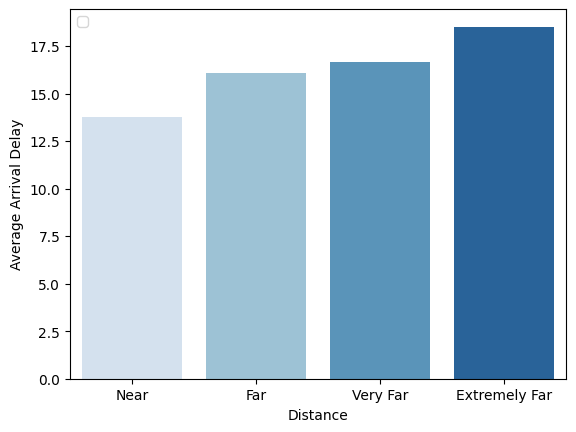

In [ ]:
bins = [0, 400, 700, 1000, np.inf]
name = ['Near', 'Far', 'Very Far', 'Extremely Far']
data['DISTANCE_GROUP'] = pd.cut(data['DISTANCE'], bins, labels = name, ordered=False, include_lowest=True, right=False)
data.head()
flights = (
    pd.DataFrame(
        df[["DISTANCE_GROUP", "ARR_DELAY"]]
        .groupby(["DISTANCE_GROUP"])["ARR_DELAY"]
        .mean()
    )
    .rename({"ArrDelayMinutes": "counts"}, axis=1)
    .reset_index()
)

sns.barplot(flights, x="DISTANCE_GROUP", y='ARR_DELAY', hue="DISTANCE_GROUP", palette="Blues")
plt.legend([])
plt.ylabel("Average Arrival Delay")
plt.xlabel("Distance")
plt.show()

# PRE-PROCESSING AND OUTLIER DETECTION

In [ ]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Assuming 'data' is your DataFrame
# Select numerical columns for imputation (MICE works best with numerical data)
numerical_data = df.select_dtypes(include=['number'])

# Create an IterativeImputer instance
imputer = IterativeImputer(max_iter=10, random_state=0)  # Adjust parameters as needed

# Impute missing values
imputed_data = imputer.fit_transform(numerical_data)

# Create a new DataFrame with imputed values
imputed_df = pd.DataFrame(imputed_data, columns=numerical_data.columns, index=numerical_data.index)

# If needed, replace original numerical columns with imputed ones in the original DataFrame
df[numerical_data.columns] = imputed_df

In [ ]:
df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'year', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR',
       'DEST_AIRPORT_ID', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEP_TIME', 'CANCELLED', 'DIVERTED', 'ARR_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'CARRIER_DELAY',
                 'WEATHER_DELAY', 'NAS_DELAY', 'IsDelayed','TAIL_NUM','DEST','DATE','Status','DISTANCE_GROUP','WEEK','departure_date'], inplace=True)

In [ ]:
df

,QUARTER,month,day,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,CRS_DEP_TIME,DEP_DELAY,TAXI_OUT,TAXI_IN,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,CONGESTION,weekly_carrier_delay,departure_hour,peak_1,peak_2,temp(in celsius),wind_speed,dew_point,humidity,pressure,weather_code,precipitation
0,1.0,1.0,1.0,7.0,9E,ATL,825.0,16.0,12.0,4.0,829.0,2.0,64.0,147.0,0.0,0.0,686.0,6.719019,8.0,1.0,0.0,10.8,0.0,10.8,100.0,1017.5,5.0,0.0
1,1.0,1.0,1.0,7.0,9E,ATL,950.0,-3.0,29.0,4.0,1214.0,0.0,144.0,780.0,0.0,0.0,686.0,6.719019,9.0,0.0,0.0,11.9,0.0,11.9,100.0,1017.2,5.0,0.0
2,1.0,1.0,1.0,7.0,9E,ATL,1710.0,-5.0,11.0,5.0,1814.0,0.0,64.0,238.0,0.0,0.0,686.0,6.719019,17.0,0.0,0.0,20.3,13.0,11.5,57.0,1018.3,3.0,0.0
3,1.0,1.0,1.0,7.0,9E,ATL,839.0,-10.0,19.0,4.0,906.0,0.0,87.0,302.0,0.0,0.0,686.0,6.719019,8.0,1.0,0.0,10.8,0.0,10.8,100.0,1017.5,5.0,0.0
4,1.0,1.0,1.0,7.0,9E,ATL,900.0,-4.0,26.0,4.0,1023.0,0.0,83.0,377.0,0.0,0.0,686.0,6.719019,9.0,0.0,0.0,10.8,0.0,10.8,100.0,1017.5,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199884,4.0,12.0,31.0,7.0,YX,ORD,1400.0,-2.0,52.0,5.0,1727.0,14.0,147.0,733.0,0.0,0.0,619.0,0.844362,14.0,0.0,0.0,-0.6,9.4,-1.7,92.0,1011.0,14.0,0.2
199885,4.0,12.0,31.0,7.0,YX,ORD,1510.0,-5.0,34.0,7.0,1732.0,6.0,82.0,286.0,0.0,0.0,619.0,0.844362,15.0,0.0,0.0,0.0,16.6,-2.2,85.0,1012.6,14.0,0.5
199886,4.0,12.0,31.0,7.0,YX,ATL,731.0,-6.0,78.0,3.0,920.0,47.0,109.0,547.0,0.0,0.0,766.0,0.844362,7.0,0.0,0.0,-1.4,0.0,-2.5,92.0,1021.3,1.0,0.0
199887,4.0,12.0,31.0,7.0,YX,ORD,715.0,-6.0,62.0,7.0,929.0,22.0,74.0,177.0,0.0,0.0,619.0,0.844362,7.0,0.0,0.0,1.7,20.5,-2.8,72.0,1010.4,4.0,0.0


In [ ]:
import pandas as pd
from sklearn.preprocessing import RobustScaler

# Specify the columns you want to scale
columns_to_scale = [ 'CRS_ELAPSED_TIME',
                    'ARR_DELAY','TAXI_OUT', 'TAXI_IN','DISTANCE',
                      'SECURITY_DELAY','LATE_AIRCRAFT_DELAY','CONGESTION','weekly_carrier_delay','temp(in celsius)','wind_speed','dew_point','humidity','pressure']

# Create a RobustScaler instance
scaler = RobustScaler()

# Fit the scaler to the selected columns and transform them
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [ ]:
df.drop(columns=['TAXI_IN'],inplace=True)

In [ ]:
df

,QUARTER,month,day,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,CRS_DEP_TIME,DEP_DELAY,TAXI_OUT,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,CONGESTION,weekly_carrier_delay,departure_hour,peak_1,peak_2,temp(in celsius),wind_speed,dew_point,humidity,pressure,weather_code,precipitation
0,1.0,1.0,1.0,7.0,9E,ATL,825.0,16.0,-0.555556,829.0,0.166667,-0.895522,-0.929889,0.0,0.0,-0.533742,0.421893,8.0,1.0,0.0,-0.701052,-1.355012,0.082370,1.376534,0.205902,5.0,0.0
1,1.0,1.0,1.0,7.0,9E,ATL,950.0,-3.0,1.333333,1214.0,0.000000,0.298507,0.238007,0.0,0.0,-0.533742,0.421893,9.0,0.0,0.0,-0.588807,-1.355012,0.177197,1.376534,0.155055,5.0,0.0
2,1.0,1.0,1.0,7.0,9E,ATL,1710.0,-5.0,-0.666667,1814.0,0.000000,-0.895522,-0.761993,0.0,0.0,-0.533742,0.421893,17.0,0.0,0.0,0.268336,0.089432,0.142714,-0.277312,0.341495,3.0,0.0
3,1.0,1.0,1.0,7.0,9E,ATL,839.0,-10.0,0.222222,906.0,0.000000,-0.552239,-0.643911,0.0,0.0,-0.533742,0.421893,8.0,1.0,0.0,-0.701052,-1.355012,0.082370,1.376534,0.205902,5.0,0.0
4,1.0,1.0,1.0,7.0,9E,ATL,900.0,-4.0,1.000000,1023.0,0.000000,-0.611940,-0.505535,0.0,0.0,-0.533742,0.421893,9.0,0.0,0.0,-0.701052,-1.355012,0.082370,1.376534,0.205902,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199884,4.0,12.0,31.0,7.0,YX,ORD,1400.0,-2.0,3.888889,1727.0,1.166667,0.343284,0.151292,0.0,0.0,-0.944785,-1.174214,14.0,0.0,0.0,-1.864317,-0.310568,-0.995217,1.068841,-0.895793,14.0,0.2
199885,4.0,12.0,31.0,7.0,YX,ORD,1510.0,-5.0,1.888889,1732.0,0.500000,-0.626866,-0.673432,0.0,0.0,-0.944785,-1.174214,15.0,0.0,0.0,-1.803093,0.489432,-1.038320,0.799611,-0.624606,14.0,0.5
199886,4.0,12.0,31.0,7.0,YX,ATL,731.0,-6.0,6.777778,920.0,3.916667,-0.223881,-0.191882,0.0,0.0,-0.042945,-1.174214,7.0,0.0,0.0,-1.945950,-1.355012,-1.064182,1.068841,0.849970,1.0,0.0
199887,4.0,12.0,31.0,7.0,YX,ORD,715.0,-6.0,5.000000,929.0,1.833333,-0.746269,-0.874539,0.0,0.0,-0.944785,-1.174214,7.0,0.0,0.0,-1.629623,0.922766,-1.090044,0.299611,-0.997488,4.0,0.0


In [ ]:
data=df.drop(columns=['OP_UNIQUE_CARRIER','ORIGIN'])
features = data.values

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=2500, min_samples=50)
data['cluster'] = clusterer.fit_predict(features)
data['cluster'].value_counts()

,count
cluster,
-1,25019
23,7392
38,7190
32,6566
1,6441
0,6235
34,6073
27,5837
33,5695


In [ ]:
df['cluster']=data['cluster']

In [ ]:
df

,QUARTER,month,day,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,CRS_DEP_TIME,DEP_DELAY,TAXI_OUT,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,CONGESTION,weekly_carrier_delay,departure_hour,peak_1,peak_2,temp(in celsius),wind_speed,dew_point,humidity,pressure,weather_code,precipitation,cluster
0,1.0,1.0,1.0,7.0,9E,ATL,825.0,16.0,-0.555556,829.0,0.166667,-0.895522,-0.929889,0.0,0.0,-0.533742,0.421893,8.0,1.0,0.0,-0.701052,-1.355012,0.082370,1.376534,0.205902,5.0,0.0,-1
1,1.0,1.0,1.0,7.0,9E,ATL,950.0,-3.0,1.333333,1214.0,0.000000,0.298507,0.238007,0.0,0.0,-0.533742,0.421893,9.0,0.0,0.0,-0.588807,-1.355012,0.177197,1.376534,0.155055,5.0,0.0,9
2,1.0,1.0,1.0,7.0,9E,ATL,1710.0,-5.0,-0.666667,1814.0,0.000000,-0.895522,-0.761993,0.0,0.0,-0.533742,0.421893,17.0,0.0,0.0,0.268336,0.089432,0.142714,-0.277312,0.341495,3.0,0.0,29
3,1.0,1.0,1.0,7.0,9E,ATL,839.0,-10.0,0.222222,906.0,0.000000,-0.552239,-0.643911,0.0,0.0,-0.533742,0.421893,8.0,1.0,0.0,-0.701052,-1.355012,0.082370,1.376534,0.205902,5.0,0.0,3
4,1.0,1.0,1.0,7.0,9E,ATL,900.0,-4.0,1.000000,1023.0,0.000000,-0.611940,-0.505535,0.0,0.0,-0.533742,0.421893,9.0,0.0,0.0,-0.701052,-1.355012,0.082370,1.376534,0.205902,5.0,0.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199884,4.0,12.0,31.0,7.0,YX,ORD,1400.0,-2.0,3.888889,1727.0,1.166667,0.343284,0.151292,0.0,0.0,-0.944785,-1.174214,14.0,0.0,0.0,-1.864317,-0.310568,-0.995217,1.068841,-0.895793,14.0,0.2,27
199885,4.0,12.0,31.0,7.0,YX,ORD,1510.0,-5.0,1.888889,1732.0,0.500000,-0.626866,-0.673432,0.0,0.0,-0.944785,-1.174214,15.0,0.0,0.0,-1.803093,0.489432,-1.038320,0.799611,-0.624606,14.0,0.5,27
199886,4.0,12.0,31.0,7.0,YX,ATL,731.0,-6.0,6.777778,920.0,3.916667,-0.223881,-0.191882,0.0,0.0,-0.042945,-1.174214,7.0,0.0,0.0,-1.945950,-1.355012,-1.064182,1.068841,0.849970,1.0,0.0,5
199887,4.0,12.0,31.0,7.0,YX,ORD,715.0,-6.0,5.000000,929.0,1.833333,-0.746269,-0.874539,0.0,0.0,-0.944785,-1.174214,7.0,0.0,0.0,-1.629623,0.922766,-1.090044,0.299611,-0.997488,4.0,0.0,5


#FEATURE SELECTION

In [ ]:
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

categorical_features = ['OP_UNIQUE_CARRIER', 'ORIGIN']
df[categorical_features] = df[categorical_features].astype(str)
X = df.drop(columns=['cluster','ARR_DELAY'])
y = df['ARR_DELAY']
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)
feature_names = ['F{}'.format(i) for i in range(train_X.shape[1])]

# Specify categorical features when creating the Pool
train_pool = Pool(train_X, train_y, cat_features=categorical_features)
test_pool = Pool(test_X, test_y, cat_features=categorical_features)

model = CatBoostRegressor(iterations=1000, random_seed=0)
summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select='0-25',
    num_features_to_select=18,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
import pandas as pd
categorical_features = ['OP_UNIQUE_CARRIER', 'ORIGIN']
df = pd.get_dummies(df, columns=categorical_features, prefix=categorical_features, drop_first=True)

In [ ]:
df

,QUARTER,month,day,DAY_OF_WEEK,CRS_DEP_TIME,DEP_DELAY,TAXI_OUT,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,CONGESTION,weekly_carrier_delay,departure_hour,peak_1,peak_2,temp(in celsius),wind_speed,dew_point,humidity,pressure,weather_code,precipitation,cluster,OP_UNIQUE_CARRIER_AA,OP_UNIQUE_CARRIER_AS,OP_UNIQUE_CARRIER_B6,OP_UNIQUE_CARRIER_DL,OP_UNIQUE_CARRIER_F9,OP_UNIQUE_CARRIER_MQ,OP_UNIQUE_CARRIER_NK,OP_UNIQUE_CARRIER_OH,OP_UNIQUE_CARRIER_OO,OP_UNIQUE_CARRIER_UA,OP_UNIQUE_CARRIER_WN,OP_UNIQUE_CARRIER_YX,ORIGIN_CLT,ORIGIN_DEN,ORIGIN_DFW,ORIGIN_ORD
0,1.0,1.0,1.0,7.0,825.0,16.0,-0.555556,829.0,0.166667,-0.895522,-0.929889,0.0,0.0,-0.533742,0.421893,8.0,1.0,0.0,-0.701052,-1.355012,0.082370,1.376534,0.205902,5.0,0.0,-1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,1.0,1.0,1.0,7.0,950.0,-3.0,1.333333,1214.0,0.000000,0.298507,0.238007,0.0,0.0,-0.533742,0.421893,9.0,0.0,0.0,-0.588807,-1.355012,0.177197,1.376534,0.155055,5.0,0.0,9,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,1.0,1.0,1.0,7.0,1710.0,-5.0,-0.666667,1814.0,0.000000,-0.895522,-0.761993,0.0,0.0,-0.533742,0.421893,17.0,0.0,0.0,0.268336,0.089432,0.142714,-0.277312,0.341495,3.0,0.0,29,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,1.0,1.0,1.0,7.0,839.0,-10.0,0.222222,906.0,0.000000,-0.552239,-0.643911,0.0,0.0,-0.533742,0.421893,8.0,1.0,0.0,-0.701052,-1.355012,0.082370,1.376534,0.205902,5.0,0.0,3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,1.0,1.0,1.0,7.0,900.0,-4.0,1.000000,1023.0,0.000000,-0.611940,-0.505535,0.0,0.0,-0.533742,0.421893,9.0,0.0,0.0,-0.701052,-1.355012,0.082370,1.376534,0.205902,5.0,0.0,11,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199884,4.0,12.0,31.0,7.0,1400.0,-2.0,3.888889,1727.0,1.166667,0.343284,0.151292,0.0,0.0,-0.944785,-1.174214,14.0,0.0,0.0,-1.864317,-0.310568,-0.995217,1.068841,-0.895793,14.0,0.2,27,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
199885,4.0,12.0,31.0,7.0,1510.0,-5.0,1.888889,1732.0,0.500000,-0.626866,-0.673432,0.0,0.0,-0.944785,-1.174214,15.0,0.0,0.0,-1.803093,0.489432,-1.038320,0.799611,-0.624606,14.0,0.5,27,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
199886,4.0,12.0,31.0,7.0,731.0,-6.0,6.777778,920.0,3.916667,-0.223881,-0.191882,0.0,0.0,-0.042945,-1.174214,7.0,0.0,0.0,-1.945950,-1.355012,-1.064182,1.068841,0.849970,1.0,0.0,5,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
199887,4.0,12.0,31.0,7.0,715.0,-6.0,5.000000,929.0,1.833333,-0.746269,-0.874539,0.0,0.0,-0.944785,-1.174214,7.0,0.0,0.0,-1.629623,0.922766,-1.090044,0.299611,-0.997488,4.0,0.0,5,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True


#MODEL TESTING AND SELECTION

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
dat = df.dropna()
dat = dat.drop(dat[dat['cluster'] == -1].index)
X = dat.drop(['ARR_DELAY','cluster','CRS_DEP_TIME','CRS_ARR_TIME','day','CONGESTION'],axis=1)
y = dat['ARR_DELAY']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = CatBoostRegressor(n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R2 overall:",r2)

Learning rate set to 0.5
0:	learn: 1.1518143	total: 50.9ms	remaining: 5.04s
1:	learn: 0.8433388	total: 99.1ms	remaining: 4.86s
2:	learn: 0.7015904	total: 155ms	remaining: 5s
3:	learn: 0.6333855	total: 204ms	remaining: 4.9s
4:	learn: 0.5997633	total: 254ms	remaining: 4.83s
5:	learn: 0.5850534	total: 306ms	remaining: 4.8s
6:	learn: 0.5752557	total: 355ms	remaining: 4.72s
7:	learn: 0.5670092	total: 421ms	remaining: 4.84s
8:	learn: 0.5624291	total: 470ms	remaining: 4.75s
9:	learn: 0.5571324	total: 534ms	remaining: 4.8s
10:	learn: 0.5522215	total: 591ms	remaining: 4.78s
11:	learn: 0.5491767	total: 652ms	remaining: 4.78s
12:	learn: 0.5460178	total: 712ms	remaining: 4.76s
13:	learn: 0.5438143	total: 764ms	remaining: 4.7s
14:	learn: 0.5419059	total: 811ms	remaining: 4.6s
15:	learn: 0.5399907	total: 865ms	remaining: 4.54s
16:	learn: 0.5381393	total: 930ms	remaining: 4.54s
17:	learn: 0.5355211	total: 990ms	remaining: 4.51s
18:	learn: 0.5340095	total: 1.05s	remaining: 4.47s
19:	learn: 0.5327412	t

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
# Train the Random Forest model
mod = XGBRegressor(n_estimators=100, random_state=42)
mod.fit(X_train, y_train)
predictions = mod.predict(X_test)
# Evaluate the model
r2 = r2_score(y_test, predictions)
print(f'R2: {r2}')

R2: 0.8059800397776854


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

mod = LinearRegression()
mod.fit(X_train, y_train)
predictions = mod.predict(X_test)
# Evaluate the model
accuracy = r2_score(y_test, predictions)
print(f'R2: {accuracy}')

R2: 0.8678498965641815


In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

mod = LGBMRegressor(n_estimators=100, random_state=42)
mod.fit(X_train, y_train)
predictions = mod.predict(X_test)
# Evaluate the model
accuracy = r2_score(y_test, predictions)
print(f'R2: {accuracy}')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3164
[LightGBM] [Info] Number of data points in the train set: 139896, number of used features: 36
[LightGBM] [Info] Start training from score 0.719399
R2: 0.9126701769570107


In [ ]:
'''from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

def objective(search_space):
    model = CatBoostRegressor(**search_space,
                              loss_function='RMSE',
                              eval_metric='R2',
                              early_stopping_rounds=100,
                              random_seed=69)

    model.fit(X = X_train, y = y_train, eval_set=(X_test,y_test), verbose=False)
    return {'loss': model.get_best_score()['validation']['RMSE'], 'status': STATUS_OK}

search_space = {'learning_rate': hp.uniform('learning_rate', 0.1, 0.5),
                'iterations': hp.randint('iterations',100,1000),
                'l2_leaf_reg': hp.randint('l2_leaf_reg',1,10),
                'depth': hp.randint('depth',4,10),
                'bootstrap_type' : hp.choice('bootstrap_type', ['Bayesian', 'Bernoulli'])}

algorithm=tpe.suggest

best_params = fmin(
  fn=objective,
  space=search_space,
  algo=algorithm,
  max_evals=50)

hyperparams = space_eval(search_space, best_params)

params = {'learning_rate' : hyperparams['learning_rate'],
          'iterations' : hyperparams['iterations'],
          'depth' : hyperparams['depth'],
          'loss_function' : 'RMSE',
          'l2_leaf_reg' : hyperparams['l2_leaf_reg'],
          'eval_metric' : 'R2',
          'early_stopping_rounds': 100,
          'bootstrap_type' : hyperparams['bootstrap_type']}

model = CatBoostRegressor(**params, random_seed=42)
model.fit(X = X_train, y = y_train, eval_set=(X_test,y_test),verbose=250)

print('best RMSE', model.get_best_score()['validation']['RMSE'])'''

"from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK\n\ndef objective(search_space):\n    model = CatBoostRegressor(**search_space,\n                              loss_function='RMSE',\n                              eval_metric='R2',\n                              early_stopping_rounds=100,\n                              random_seed=69)\n\n    model.fit(X = X_train, y = y_train, eval_set=(X_test,y_test), verbose=False)\n    return {'loss': model.get_best_score()['validation']['RMSE'], 'status': STATUS_OK}\n\nsearch_space = {'learning_rate': hp.uniform('learning_rate', 0.1, 0.5),\n                'iterations': hp.randint('iterations',100,1000),\n                'l2_leaf_reg': hp.randint('l2_leaf_reg',1,10),\n                'depth': hp.randint('depth',4,10),\n                'bootstrap_type' : hp.choice('bootstrap_type', ['Bayesian', 'Bernoulli'])}\n\nalgorithm=tpe.suggest\n\nbest_params = fmin(\n  fn=objective,\n  space=search_space,\n  algo=algorithm,\n  max_evals=50)\n\

#FINAL MODEL

In [ ]:
X_train, X_te, y_train, y_te = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [ ]:
model = CatBoostRegressor(bootstrap_type='Bernoulli',depth=7,iterations=977,
                          l2_leaf_reg=1,learning_rate=0.15358073111172976,
                          random_seed=42)
model.fit(X = X_train, y = y_train, eval_set=(X_test,y_test),verbose=250)
y_pred = model.predict(X_te)
r2 = r2_score(y_te, y_pred)
print(f"R2 overall:",r2)

0:	learn: 1.6040790	test: 1.5548932	best: 1.5548932 (0)	total: 18ms	remaining: 17.6s
250:	learn: 0.4587268	test: 0.5055414	best: 0.5055414 (250)	total: 5.55s	remaining: 16.1s
500:	learn: 0.4206028	test: 0.4979279	best: 0.4979136 (499)	total: 12.8s	remaining: 12.2s
750:	learn: 0.3926702	test: 0.4946088	best: 0.4946088 (750)	total: 17.9s	remaining: 5.4s
976:	learn: 0.3724782	test: 0.4922579	best: 0.4922579 (976)	total: 25.3s	remaining: 0us

bestTest = 0.4922579189
bestIteration = 976

R2 overall: 0.9193801485771561


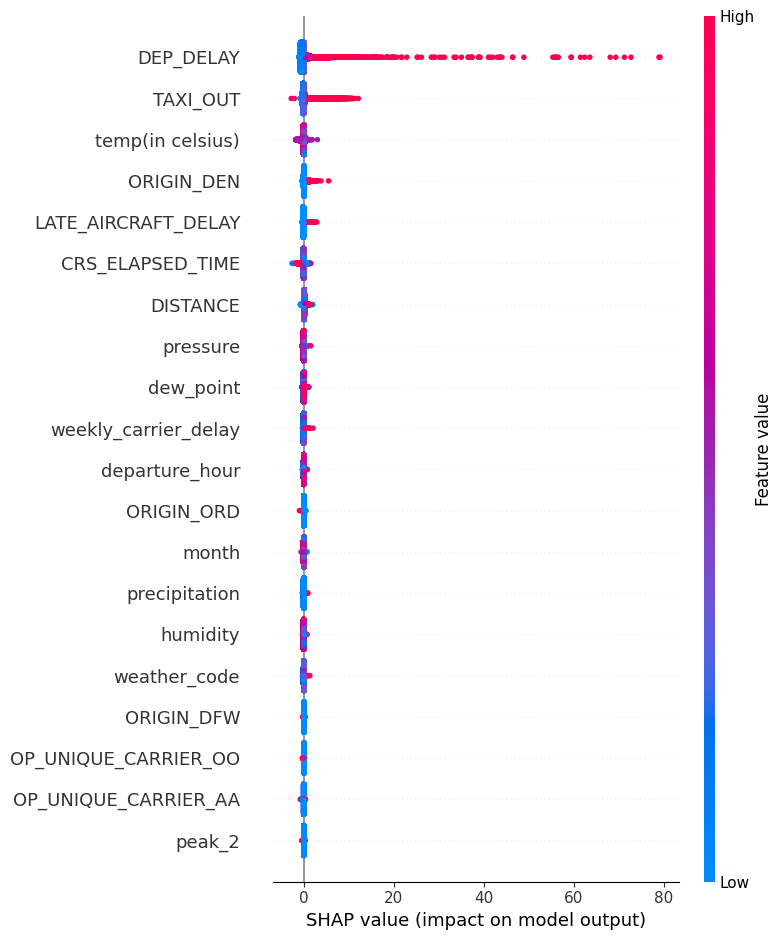

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)
shap.summary_plot(shap_values, X)